# CoDA multi-run metrics (mean ± SE bands)

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from typing import List

from spatial_environments import GridEnvRightDownNoSelf, GridEnvRightDownNoCue
from util import generate_dataset, generate_dataset_post_augmentation
from coda_metrics import kl_over_time, entropy_over_time, markovization_score, ref_empirical_from_rollouts, greedy_right_down_policy
from coda_trial_by_trial_util import CoDAAgent, CoDAConfig

N_SEEDS   = 30
SEED0     = 0
N_ACQ     = 250
N_EXT     = 300
MAX_STEPS = 20
CUE       = 5

cfg = CoDAConfig(
    theta_split=0.6, theta_merge=0.5,
    n_threshold=8, min_presence_episodes=3, min_effective_exposure=5.0,
    confidence=0.8,
    count_decay=0.9,
    trace_decay=0.9,
    retro_decay=0.9
)

N_ROLL_REF = 300

# # --- Config ---
# CUE = 5
# THRESH = 0.3               # must match env.plot_graph threshold
# cfg = CoDAConfig(
#     theta_split=0.6, theta_merge=0.5,
#     n_threshold=8, min_presence_episodes=3, min_effective_exposure=5.0,
#     confidence=0.8, 
#     count_decay=0.9, 
#     # trace_decay=0.9,    # makes PC recent
#     # retro_decay=0.9     # makes RC recent
# )


# # cfg.theta_split = 0.85
# N_ACQ, N_EXT = 250, 300
# MAX_STEPS = 20

# env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
# agent = CoDAAgent(env, cfg)


In [ ]:

def ref_builder_factory(env, policy_fn, nroll=300, max_steps=20):
    def _make_ref(T_learned):
        return ref_empirical_from_rollouts(env, policy_fn, n_episodes=nroll, max_steps=max_steps)
    return _make_ref

def run_one_seed(seed:int):
    np.random.seed(seed)

    env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    agent = CoDAAgent(env, cfg)

    T_series_acq: List[np.ndarray] = []
    with_clones = False
    for ep in range(1, N_ACQ+1):
        if with_clones:
            (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        else:
            (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        if agent.maybe_split():
            with_clones = True
        T_series_acq.append(agent.get_T().copy())

    env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    env2.clone_dict = dict(getattr(env, "clone_dict", {}))
    env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
    agent.env = env2

    T_series_ext: List[np.ndarray] = []
    for ep in range(N_ACQ+1, N_ACQ+N_EXT+1):
        (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        agent.maybe_merge()
        T_series_ext.append(agent.get_T().copy())

    ref_fn_acq = ref_builder_factory(env,  greedy_right_down_policy, nroll=N_ROLL_REF, max_steps=MAX_STEPS)
    ref_fn_ext = ref_builder_factory(env2, greedy_right_down_policy, nroll=N_ROLL_REF, max_steps=MAX_STEPS)

    KL_acq = kl_over_time(T_series_acq, ref_fn_acq, use_js=False)
    JS_acq = kl_over_time(T_series_acq, ref_fn_acq, use_js=True)
    H_acq  = entropy_over_time(T_series_acq)
    MS_acq = np.array([markovization_score(T) for T in T_series_acq])

    KL_ext = kl_over_time(T_series_ext, ref_fn_ext, use_js=False)
    JS_ext = kl_over_time(T_series_ext, ref_fn_ext, use_js=True)
    H_ext  = entropy_over_time(T_series_ext)
    MS_ext = np.array([markovization_score(T) for T in T_series_ext])

    return dict(KL_acq=KL_acq, JS_acq=JS_acq, H_acq=H_acq, MS_acq=MS_acq,
                KL_ext=KL_ext, JS_ext=JS_ext, H_ext=H_ext, MS_ext=MS_ext)


In [3]:

# run many seeds
results = []
for k in range(N_SEEDS):
    res = run_one_seed(SEED0 + k)
    results.append(res)

def _pad_stack(arrs):
    L = max(len(a) for a in arrs)
    M = np.full((len(arrs), L), np.nan)
    for i,a in enumerate(arrs):
        M[i,:len(a)] = a
    return M

def mean_se(arrs):
    M = _pad_stack(arrs)
    mean = np.nanmean(M, axis=0)
    se   = np.nanstd(M, axis=0, ddof=max(1,min(len(arrs)-1,1))) / np.sqrt(max(1,len(arrs)))
    return mean, se

KL_acq_runs = [r["KL_acq"] for r in results]
JS_acq_runs = [r["JS_acq"] for r in results]
H_acq_runs  = [r["H_acq"]  for r in results]
MS_acq_runs = [r["MS_acq"] for r in results]

KL_ext_runs = [r["KL_ext"] for r in results]
JS_ext_runs = [r["JS_ext"] for r in results]
H_ext_runs  = [r["H_ext"]  for r in results]
MS_ext_runs = [r["MS_ext"] for r in results]


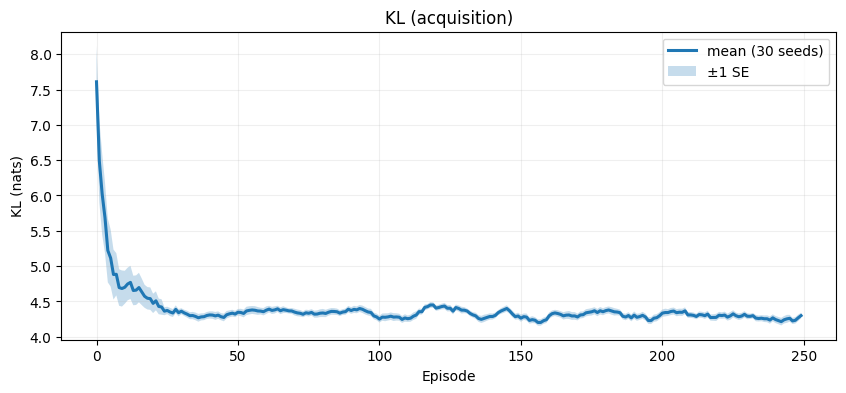

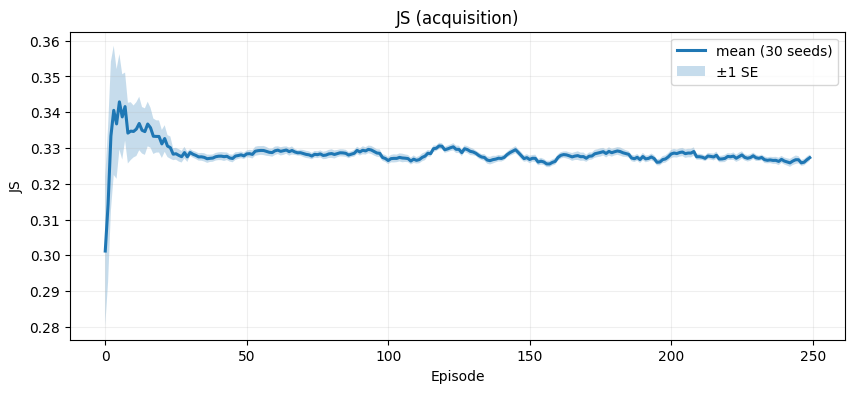

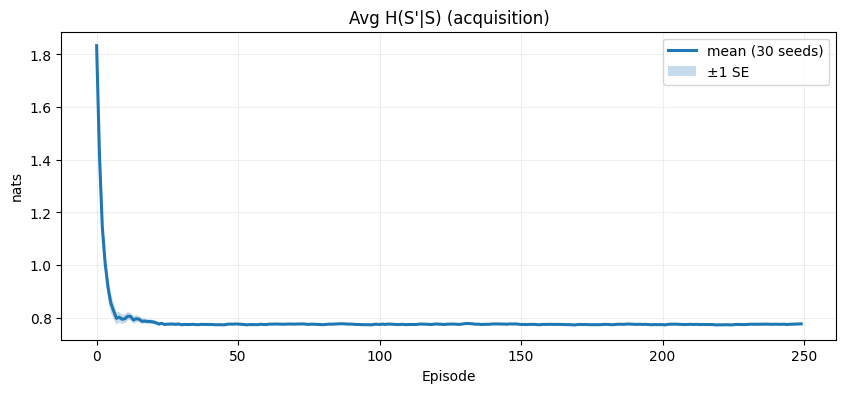

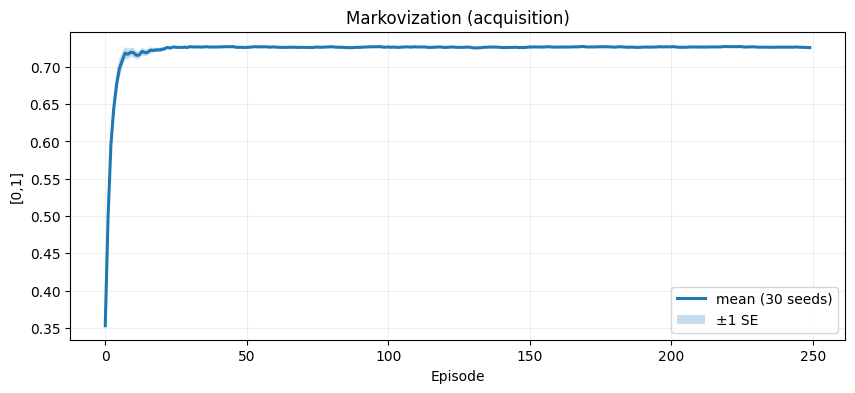

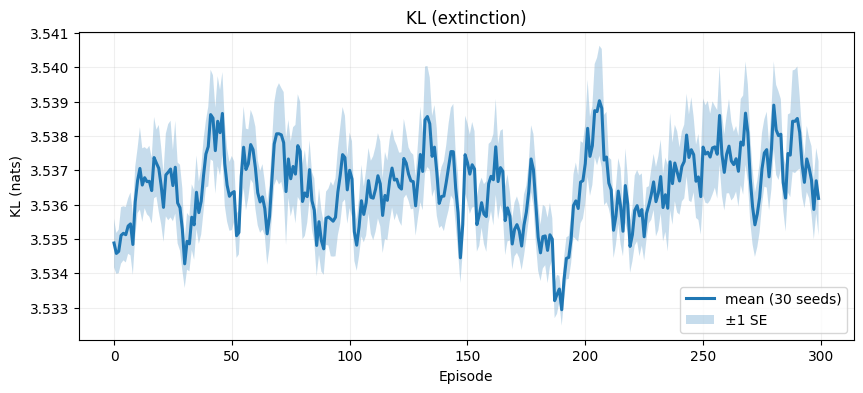

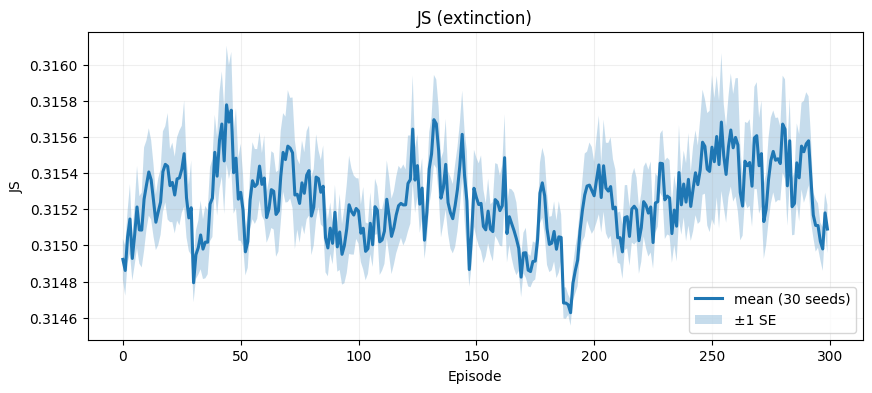

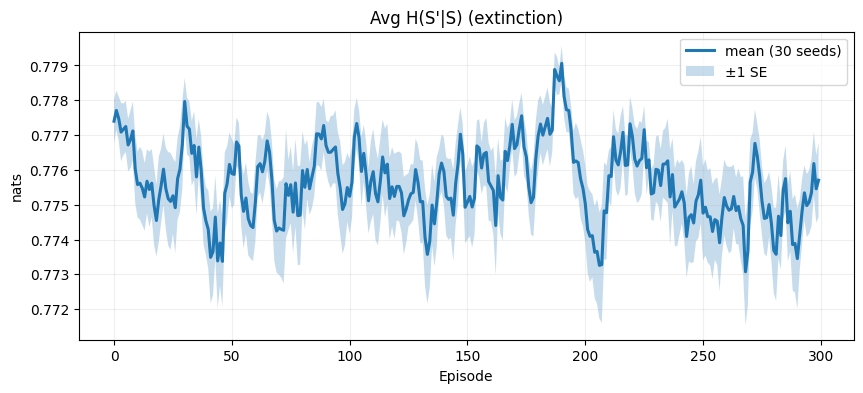

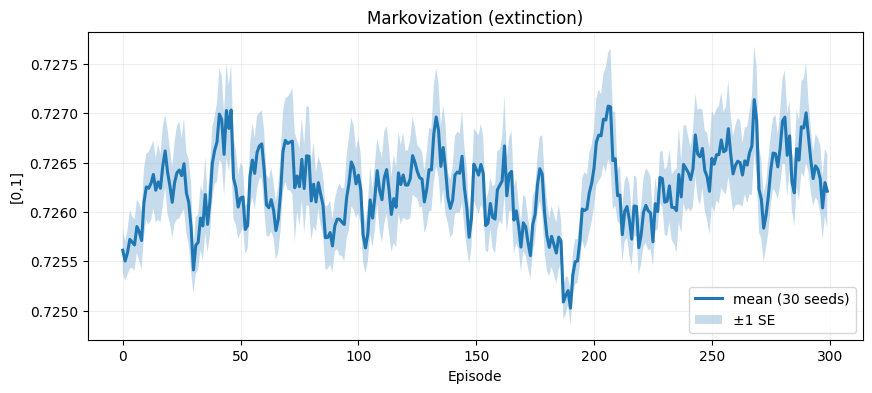

In [4]:

def plot_band(y_runs, title, ylabel):
    mean, se = mean_se(y_runs)
    x = np.arange(len(mean))
    plt.plot(x, mean, lw=2.2, label=f"mean ({len(y_runs)} seeds)")
    plt.fill_between(x, mean-se, mean+se, alpha=0.25, label="±1 SE")
    plt.title(title); plt.xlabel("Episode"); plt.ylabel(ylabel); plt.legend(); plt.grid(alpha=0.2)

plt.figure(figsize=(10,4)); plot_band(KL_acq_runs, "KL (acquisition)", "KL (nats)"); plt.show()
plt.figure(figsize=(10,4)); plot_band(JS_acq_runs, "JS (acquisition)", "JS"); plt.show()
plt.figure(figsize=(10,4)); plot_band(H_acq_runs,  "Avg H(S'|S) (acquisition)", "nats"); plt.show()
plt.figure(figsize=(10,4)); plot_band(MS_acq_runs, "Markovization (acquisition)", "[0,1]"); plt.show()

plt.figure(figsize=(10,4)); plot_band(KL_ext_runs, "KL (extinction)", "KL (nats)"); plt.show()
plt.figure(figsize=(10,4)); plot_band(JS_ext_runs, "JS (extinction)", "JS"); plt.show()
plt.figure(figsize=(10,4)); plot_band(H_ext_runs,  "Avg H(S'|S) (extinction)", "nats"); plt.show()
plt.figure(figsize=(10,4)); plot_band(MS_ext_runs, "Markovization (extinction)", "[0,1]"); plt.show()
